# Projekt

## Import potrzebnych bibliotek

In [54]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler,StandardScaler,FunctionTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

## Wczytanie danych

In [28]:
X = pd.read_csv("C:/Users/julia/Downloads/artifical_train_data.csv")
X_test = pd.read_csv("C:/Users/julia/Downloads/artifical_test_data.csv")
X_all = pd.concat([X,X_test],axis =0)

y = pd.read_csv("C:/Users/julia/Downloads/artifical_train_labels.csv")
# należy to wykonać ponieważ xgboost przyjmuje 0 i 1
y['0'] = (y['0'] + 1) // 2
y = y[['0']]

## Braki danych

In [29]:
missing_values = X.isnull().sum()
columns_with_missing_values = missing_values[missing_values > 0].index
print(f"Kolumny z brakującymi danymi: {columns_with_missing_values}")

zeros_in_columns = (X == 0).any()
columns_with_zeros = zeros_in_columns[zeros_in_columns].index
print(f"Kolumny z zerami: {columns_with_zeros}")

Kolumny z brakującymi danymi: Index([], dtype='object')
Kolumny z zerami: Index([], dtype='object')


## Outliery

In [30]:
# Dla każdej kolumny w ramce danych
for column in X_all.columns:
    
    if np.issubdtype(X_all[column].dtype, np.number):
        # Obliczenie IQR 
        Q1 = X_all[column].quantile(0.25)
        Q3 = X_all[column].quantile(0.75)
        IQR = Q3 - Q1

        
        outliers = ((X_all[column] < (Q1 - 1.5 * IQR)) | (X_all[column] > (Q3 + 1.5 * IQR)))

        # Zamiana outlierów na średnią pozostałych wartości w kolumnie
        X_all.loc[outliers, column] = X_all.loc[~outliers, column].mean()
 

## Mapa ciepła

<AxesSubplot:>

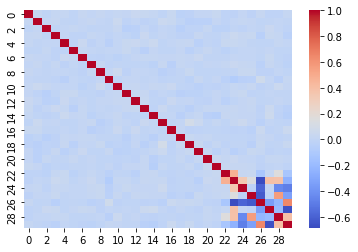

In [31]:
# Obliczenie macierzy korelacji
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm")

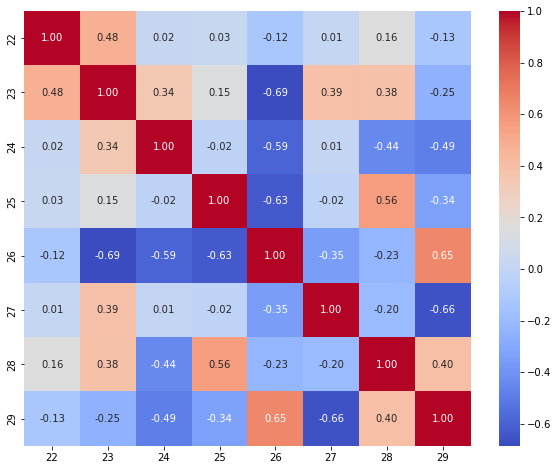

In [32]:
# Wybór tylko cech od 22 do 29
selected_features = X.iloc[:, 22:30]

correlation_matrix_selected = selected_features.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_selected, annot=True, cmap="coolwarm", fmt=".2f")
plt.show()

## Najważniejsze cechy

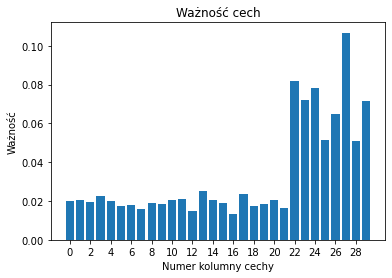

In [33]:

model = XGBClassifier()

model.fit(X, y)

#ważnośc cech
importance = model.feature_importances_

# Wykreśl ważność cech z numerami kolumn
plt.bar(np.arange(len(importance)), importance)
plt.xlabel('Numer kolumny cechy')
plt.ylabel('Ważność')
plt.title('Ważność cech')
plt.xticks(np.arange(0, len(importance), step=2))

plt.show()

# normalizacja ważności cech, aby sumowały się do 1
weights = importance / np.sum(importance)

## Skalowanie danych

In [34]:
scaler = StandardScaler()
X_all = pd.DataFrame(scaler.fit_transform(X_all), columns=X_all.columns)

## Dodanie kolumn za pomocą PCA

In [35]:
selected_features = X_all.iloc[:, 22:30]
pca = PCA(n_components=7)
principal_components = pca.fit_transform(selected_features)

pc_X = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6','38'])

X_all = pd.concat([X_all, pc_X], axis=1)

## Nowe kolumny na podstawie najważniejszych cech

In [36]:
top_features_indices = np.argsort(importance)[::-1][:6]
top_features_indices
top_features = X_all.columns[top_features_indices]
X_all['product_top_features'] = X_all[top_features].product(axis=1)
X_all['mean_top_features'] = X_all[top_features].mean(axis=1)

## Podział na zbiór treningowy, walidacyjny i testowy

In [37]:
X = X_all.iloc[0:2000,:]
X_test = X_all.iloc[2000:2600,:]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 0)

## Drzewko decyzjne 

In [57]:
#parametry do przeszukania
param_grid = {
    'max_depth': [ 15, 20, 25,30],
    'min_samples_leaf': [1, 3, 5]
}


model = DecisionTreeClassifier()


grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')


grid_search.fit(X_train, y_train_flat)

# Najlepsze znalezione hiperparametry
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# Najlepszy model
best_model = grid_search.best_estimator_
y_pred_flat = best_model.predict(X_val)
balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)
print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")


Best Hyperparameters: {'max_depth': 30, 'min_samples_leaf': 3}
Best Parameters: {'max_depth': 30, 'min_samples_leaf': 3}
Accuracy on Validation Set: 0.7624012401240123


## Regresja Logistyczna

In [51]:
param_grid = {
    'penalty': ['l1', 'l2'],    
    'C': [0.001, 0.01, 0.1, 1, 10],  
    'max_iter': [50, 100, 200]   
}


model = LogisticRegression()

grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy')


grid_search.fit(X_train, y_train_flat)


best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")


best_model = grid_search.best_estimator_

y_pred_flat = best_model.predict(X_val)


balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)

print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")


Best Hyperparameters: {'C': 0.001, 'max_iter': 50, 'penalty': 'l2'}
Accuracy on Validation Set: 0.6725


C:\Users\julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\julia\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\julia\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\julia\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1169, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)

## K Najbliższych sąsiadów

In [55]:


param_grid = {
    'n_neighbors': [3, 5, 7, 10],   
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan']  
}

model_knn = KNeighborsClassifier()


grid_search = GridSearchCV(model_knn, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train_flat)


best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")


best_model_knn = grid_search.best_estimator_

y_pred_flat_knn = best_model_knn.predict(X_val)

balanced_accuracy_knn = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat_knn)
balanced_accuracy_knn 

Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


## Najlepszy XGBoost

In [ ]:
xgb_model = XGBClassifier()

# parametry do przeszukania
param_grid = {
    'n_estimators': [190, 195,200,205,210,220],
    'learning_rate': [0.01, 0.1, 0.05,0.03],
    'max_depth': [7,10,15,20,22,25,28,29,30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}


grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='accuracy')


y_train_flat = y_train.values.ravel()

grid_search.fit(X_train, y_train_flat)

best_params = grid_search.best_params_

best_model = grid_search.best_estimator_


balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)
print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")

## Najlepszy RandomForestClassifier

In [ ]:
rf_model = RandomForestClassifier()

# parametry do przeszukania
param_grid = {
    'n_estimators': [50, 100,150, 200],
    'max_depth': [None, 10, 20,25,28, 29,30,35],
    'min_samples_split': [1,2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
    
}

grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='accuracy')


y_train_flat = y_train.values.ravel()


grid_search.fit(X_train, y_train_flat)

# Najlepsze parametry
best_params = grid_search.best_params_

# Najlepszy model
best_model = grid_search.best_estimator_

balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)

print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")


## Najlepszy BaggingClassifier 

In [7]:
bagging_model = BaggingClassifier()

# parametry do przeszukania
param_grid = {
    'n_estimators': [ 20, 50,100,150,180,190,200,210,220],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0],
}

grid_search = GridSearchCV(bagging_model, param_grid, cv=5, scoring='accuracy')

y_train_flat = y_train.values.ravel()


grid_search.fit(X_train, y_train_flat)

# Najlepsze parametry
best_params = grid_search.best_params_

# Najlepszy model
best_model = grid_search.best_estimator_


balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)

print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")

NameError: name 'y_train' is not defined

## Najlepszy SVC

In [ ]:

svm = SVC(probability = True)

#parametry do przeszukania
param_grid = {
    'C': [1,1.15,1.25]
}

grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='accuracy', verbose=1)
y_train_flat = y_train.values.ravel()
y_val_flat = y_val.values.ravel()

grid_search.fit(X_train, y_train_flat)

print("Best Parameters:", grid_search.best_params_)

best_svc = grid_search.best_estimator_

balanced_accuracy = balanced_accuracy_score(y_val.values.ravel(), y_pred_flat)

print(f"Best Parameters: {best_params}")
print(f"Accuracy on Validation Set: {balanced_accuracy}")


## Voting Classifier

In [20]:


clf1 = RandomForestClassifier(max_depth=28,
                                   
                                   min_samples_leaf=1,
                                   min_samples_split=5,
                                   n_estimators=150,random_state = 0)

clf2 = XGBClassifier(
   
    max_depth=20,
    learning_rate=0.05,
    n_estimators=200,
    min_child_weight=1,
    subsample=1,
    colsample_bytree= 0.8,
    random_state = 0
)
clf3 = BaggingClassifier(n_estimators = 200,random_state = 0,max_features = 0.5)

clf4 = SVC(probability = True,C=1.25)

# definiowanie pipeline
pipeline_ensembles = Pipeline([
    
    ('eclf', VotingClassifier(estimators=[
        ('rf', clf1),
        ('xgb', clf2),
        ('nb', clf3),
        ('svm',clf4)
    ], voting='soft', weights=[3,2,3,1]))
])

# Przekształcenie etykiety y do postaci jednowymiarowego wektora
y_train_flat = y_train.values.ravel()

pipeline_ensembles.fit(X_train, y_train_flat)


accuracy = pipeline_ensembles.score(X_val, y_val.values.ravel())
print(f"Accuracy on Validation Set: {accuracy}")

Accuracy on Validation Set: 0.8825


## Krzywa ROC

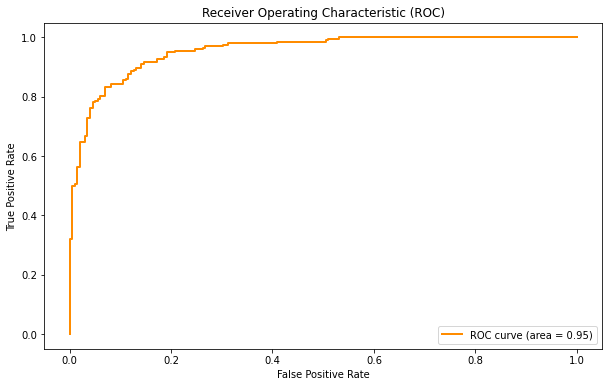

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_val_prob = pipeline_ensembles.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


## Wykorzytsanie modelu do obliczenia prawdopodobieństw należenia do klasy pierwszej dla X_test

In [22]:
clf1 = RandomForestClassifier(max_depth=28,
                                   
                                   min_samples_leaf=1,
                                   min_samples_split=5,
                                   n_estimators=150,random_state = 0)

clf2 = XGBClassifier(
   
    max_depth=20,
    learning_rate=0.05,
    n_estimators=200,
    min_child_weight=1,
    subsample=1,
    colsample_bytree= 0.8,
    random_state = 0
)
clf3 = BaggingClassifier(n_estimators = 200,random_state = 0,max_features = 0.5)

clf4 = SVC(probability = True,C=1.25)

pipeline_ensembles = Pipeline([
    
    
    ('eclf', VotingClassifier(estimators=[
        ('rf', clf1),
        ('xgb', clf2),
        ('nb', clf3),
        ('svm',clf4)
        
    ], voting='soft', weights=[3,2,3,1]))
])

#
y_flat = y.values.ravel()

pipeline_ensembles.fit(X, y_flat)

y_prob320555 = pipeline_ensembles.predict_proba(X_test)[:, 1]

array([0.15974224, 0.21702742, 0.41239128, 0.9260973 , 0.29234958,
       0.85770602, 0.27365484, 0.18056579, 0.3339271 , 0.92673954,
       0.87720186, 0.82328636, 0.18013318, 0.85992553, 0.77684231,
       0.14957995, 0.38560147, 0.92363128, 0.45989043, 0.09995339,
       0.26272096, 0.18494772, 0.08663846, 0.68537533, 0.75884412,
       0.94511239, 0.33751943, 0.34425077, 0.38118078, 0.06001   ,
       0.12611176, 0.69645078, 0.83385182, 0.57763855, 0.68476116,
       0.19585397, 0.68169864, 0.88159954, 0.63568507, 0.74092303,
       0.62560331, 0.86227115, 0.69152833, 0.71098026, 0.38938915,
       0.80673888, 0.08548863, 0.7995784 , 0.22082791, 0.32627556,
       0.91059849, 0.41911931, 0.44591427, 0.66729081, 0.78371757,
       0.25479714, 0.85464721, 0.28562484, 0.68001937, 0.12110991,
       0.87100206, 0.27805766, 0.52172435, 0.65996144, 0.78745549,
       0.44555937, 0.25573359, 0.6226045 , 0.46128369, 0.8653538 ,
       0.88397382, 0.32146839, 0.8858748 , 0.87255121, 0.66112

In [23]:
with open('y_prob320555.txt', 'w') as file:
    file.write(f'320555\n')
    for prob in y_prob320555:
        file.write(f'{prob}\n')
